In [161]:

#Author : Navneet Kumar
#Co-Author: Ayush jain

In [162]:
import cv2
import mediapipe as mp
import time
import numpy as np

In [163]:
import math
def closed_fingers(lmlist,img):
    fingers = []
    if len(lmlist) > 20:  # Ensure all landmarks are present
        cv2.putText(img, "Hand Detected", (10,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,255), 3)
        # Thumb
        if lmlist[4][2] > lmlist[3][2]:
            fingers.append("Thumb")
        # Index finger
        if lmlist[8][2] > lmlist[6][2]:
            fingers.append("Index")
        # Middle finger
        if lmlist[12][2] > lmlist[10][2]:
            fingers.append("Middle")
        # Ring finger
        if lmlist[16][2] > lmlist[14][2]:
            fingers.append("Ring")
        # Pinky
        if lmlist[20][2] > lmlist[18][2]:
            fingers.append("Pinky")

    return fingers

def finger_close_dist(tip,adj,zero):
    #two adjacent points on same finger
    # distance from zero to tip 
    dist1 = math.sqrt((zero[0] - tip[0])**2 + (zero[1] - tip[1])**2)
    dist2 =  math.sqrt((zero[0] - adj[0])**2 + (zero[1] - adj[1])**2)
    if(dist2>=dist1):
        return True
    else:
        return False

def closed_fingers_v2(lmlist,img):
    fingers = []
    if len(lmlist) > 20:  # Ensure all landmarks are present
        cv2.putText(img, "Hand Detected", (10,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 3)
        zero= lmlist[0][1],lmlist[0][2]
        # Thumb
        if finger_close_dist(lmlist[4][1:3],lmlist[3][1:3],zero):
            #add extra checks for thumb

            fingers.append("Thumb")
        # Index finger
        if finger_close_dist(lmlist[8][1:3],lmlist[6][1:3],lmlist[5][1:3]):
            fingers.append("Index")
        # Middle finger
        if finger_close_dist(lmlist[12][1:3],lmlist[10][1:3],zero):
            fingers.append("Middle")
        # Ring finger
        if finger_close_dist(lmlist[16][1:3],lmlist[14][1:3],zero):
            fingers.append("Ring")
        # Pinky
        if finger_close_dist(lmlist[20][1:3],lmlist[18][1:3],zero):
            fingers.append("Pinky")
            
    return fingers

def up_fingers(closed_list):
    open_fingers=['Thumb','Index','Middle','Ring','Pinky']
    for i in closed_list:
        open_fingers.remove(i)
    return open_fingers

def ispointing(closedfingers,img):
    if 'Middle' in closedfingers and 'Ring' in closedfingers and 'Pinky' in closedfingers and 'Index' not in closedfingers:
        cv2.putText(img, "Pointing", (10,100), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 3)
        return True
    return False


    

        

In [164]:

class writer:
    def __init__(self):
        self.points=[]
        self.Zdist=-0.05
        self.thres=0.03
        self.dir='bi'
        self.writethres=0
    def calibrate(self,currentZ,thres,dir,writethres):

        self.Zdist=currentZ
        self.thres=thres
        self.dir=dir
        self.writethres=writethres
    def on_canvas(self,point):
        if(self.dir=='bi'):
            if(abs(point.z-self.Zdist)<self.thres):
                return True
            return False
        elif(self.dir=='uni1'):
            if(point.z<self.Zdist):
                return True
            return False
        elif(self.dir=='uni2'):
            if(point.z>self.Zdist):
                return True
            return False
      
    def write(self,point):
        if(self.on_canvas(point)):
            self.points.append(point)
        # if len(self.points)>1:
            # cv2.line(self.img,self.points[-2],self.points[-1],(255,0,0),5)
    def writeV2(self,point):
        # compare with last point
        if(len(self.points)>1):
            if(math.sqrt((self.points[-1].x-point.x)**2 + (self.points[-1].y-point.y)**2)<self.writethres and self.on_canvas(point)):
                self.points.append(point)
                return True
        elif(self.on_canvas(point)):
            self.points.append(point)
            return True

        return False
    def writeV3(self,point,timegap):
        # check time gap between two points
        if(len(self.points)>0):
            if(timegap<0.5 and self.on_canvas(point)):
                self.points.append(point)
                return True
        elif(self.on_canvas(point)):
            self.points.append(point)
            return True

    def clear(self):
        self.points.clear()
    # def make_line(self,img):
    #     if len(self.points)>1:
    #         for i in range(len(self.points)-1):
    #             cv2.line(self.img,self.points[i],self.points[i+1],(255,0,0),5)
    def draw(self,img):
        if len(self.points)>1:
            for i in range(len(self.points)-1):
                cv2.line(img,(int(self.points[i].x),int(self.points[i].y)),(int(self.points[i+1].x),int(self.points[i+1].y)),(255,0,0),5)
        return img

In [165]:
class Mypoint:
    def __init__(self,x,y,z):
        self.x=x
        self.y=y
        self.z=z


In [166]:
def Draw(img,points):
    if len(points)>1:
        for i in range(len(points)-1):
            cv2.line(img,(int(points[i].x),int(points[i].y)),(int(points[i+1].x),int(points[i+1].y)),(255,0,0),5)
            

In [167]:
#a 10 length numpy array
pointer_table=np.zeros(10,dtype=bool)


In [168]:
import cv2
import threading

class VideoCaptureThreading:
    def __init__(self, src=0):
        self.src = src
        self.cap = cv2.VideoCapture(self.src)
        self.grabbed, self.frame = self.cap.read()
        self.started = False
        self.read_lock = threading.Lock()

    def set(self, var1, var2):
        self.cap.set(var1, var2)

    def start(self):
        if self.started:
            print('[!] Threaded video capturing has already been started.')
            return None
        self.started = True
        self.thread = threading.Thread(target=self.update, args=())
        self.thread.start()
        return self

    def update(self):
        while self.started:
            grabbed, frame = self.cap.read()
            with self.read_lock:
                self.grabbed = grabbed
                self.frame = frame

    def read(self):
        with self.read_lock:
            frame = self.frame.copy()
            grabbed = self.grabbed
        return grabbed, frame

    def stop(self):
        self.started = False
        self.thread.join()

    def __exit__(self, exec_type, exc_value, traceback):
        self.cap.release()

In [169]:
import threading
import time
cap = cv2.VideoCapture(0)
# cap = VideoCaptureThreading(0)
# cap.start()

CALIZ=-0.0
THRES=0.03
DIR='uni1'
WRITETHRES=1000000
NUM_TRACK_FRAMES=5

mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=False,
                      max_num_hands=1,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.7)
mpDraw = mp.solutions.drawing_utils

pTime = 0
cTime = 0
wr = writer()
wr.calibrate(currentZ=CALIZ,thres=THRES,dir=DIR,writethres=WRITETHRES)
Writers=[]
Writers.append(wr)
## POINTER TRACK TABLE
#a 10 length numpy array to track last num_track_frames frames pointing status
num_track_frames=NUM_TRACK_FRAMES
pointer_table=np.zeros(num_track_frames,dtype=bool)
pointer_table[0]=True
print(pointer_table)

last_time_pointer=False
this_time_pointer=True

Time_Instant=time.time()

while True:
 

    try:
        success, img = cap.read()
        img=cv2.flip(img,1)
  
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       
  
        results = hands.process(imgRGB)
        #print(results.multi_hand_landmarks)
        lmlist = []
       
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                for id, lm in enumerate(handLms.landmark):
                    #print(id,lm)
                    h, w, c = img.shape
                    cx, cy = int(lm.x *w), int(lm.y*h)
                    cz= lm.z
                    #if id ==0:
                    # cv2.circle(img, (cx,cy), 3, (255,0,255), cv2.FILLED)
                    # circle with numbers

                    
                    cv2.putText(img, str(id), (cx,cy), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)
                    lmlist.append([id, cx, cy, cz])

                # mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)

            
                

        def closed_fingers(lmlist):
            fingers = []
            if len(lmlist) > 20:  # Ensure all landmarks are present
                cv2.putText(img, "Hand Detected", (10,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,255), 3)
                # Thumb
                if lmlist[4][2] > lmlist[3][2]:
                    fingers.append("Thumb")
                # Index finger
                if lmlist[8][2] > lmlist[6][2]:
                    fingers.append("Index")
                # Middle finger
                if lmlist[12][2] > lmlist[10][2]:
                    fingers.append("Middle")
                # Ring finger
                if lmlist[16][2] > lmlist[14][2]:
                    fingers.append("Ring")
                # Pinky
                if lmlist[20][2] > lmlist[18][2]:
                    fingers.append("Pinky")

            return fingers
         

        c_fingers= closed_fingers_v2(lmlist,img)

        Pencil=True



        if(len(c_fingers)>0):
            cv2.putText(img, str(up_fingers(c_fingers)), (10,100), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,200), 1)

            new_point=Mypoint(lmlist[8][1],lmlist[8][2],lmlist[8][3])
            if(Writers[-1].on_canvas(new_point)):
                # glow the point
                cv2.circle(img, (int(new_point.x),int(new_point.y)), 5, (255,150,200), cv2.FILLED)
            # print("pointer ",last_time_pointer," ",this_time_pointer)
            if ispointing(c_fingers,img):
                this_time_pointer=True

                # make new writer when last num_track_frames frames were not pointing and this frame is pointing
                timegap=time.time()-Time_Instant
                if np.all(pointer_table==False) and this_time_pointer and timegap>0.1:
                    new_writer=writer()
                    new_writer.calibrate(currentZ=CALIZ,thres=THRES,dir=DIR,writethres=WRITETHRES)
                    Writers.append(new_writer)
                    
             

                
                cv2.putText(img, "Pointing", (10,100), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 3)
                
                if(Pencil ):
                    # Writers[-1].write(new_point)
                    Writers[-1].writeV2(new_point)
                    Time_Instant=time.time()

                    # print(new_point.z)
                    # wr.write(new_point)
                    # Writers[-1].write(new_point)
                last_time_pointer=True
            else:
                last_time_pointer=False
        # update last value of pointer table with last_time_pointer
        pointer_table=np.roll(pointer_table,1)
        pointer_table[0]=last_time_pointer

 
        # wr.draw(img)
       
        for Writer in Writers:
            img=Writer.draw(img)         
                    
        

        cTime = time.time()
        fps = 1/(cTime-pTime)
        pTime = cTime


        

        cv2.putText(img,str(int(fps)), (10,70), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,255), 3)
   
       
        cv2.imshow("Image", img)
        cv2.waitKey(1)

      

        if not (cv2.getWindowProperty("Image",cv2.WND_PROP_VISIBLE)):
            break
    
        if cv2.waitKey(1) == 27: 
            break  # esc to quit

    except Exception as e:
        print(e)
        break
cap.release()
cv2.destroyAllWindows()
    

[ True False False False False]


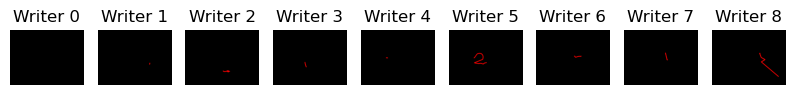

In [170]:
import matplotlib.pyplot as plt
# make images for points in each writer as separate images in subplots
# fig size 10,10
fig, axs = plt.subplots(1,len(Writers),figsize=(10,10))
new_img=np.zeros((480,640,3),dtype=np.uint8)
for i,Writer in enumerate(Writers):
    new_img.fill(0)
    new_img=Writer.draw(new_img)
    axs[i].imshow(new_img)
    axs[i].set_title('Writer '+str(i))
    axs[i].axis('off')
plt.show()
